## Rockhound Convolutional Neural Network
Author: Giovan Cervantes

#### __Description:__
The purpose of this cnn is to accurately identify minerals in photographs. This task boils down to classification, which is why I'm using a cnn as apposed to other types of neural networks. As the name suggests Cnn's have a convolutional layer which help pick up on spatial features, something a standard Neural Network can't do.

#### __Dataset Details__
The data consists of labeled images of rocks and minerals organized by their respective types.

There are two sets of data, the [__training data__](#training-data-processing) and the [__testing data__](#test-data-processing). Each set follows the same structure outlined above, with the only difference coming from how the images are preprocessed. <br><br>

***

#### Step 1: Load Dataset
Here I'm looping through the dataset folder, creating a list of image paths and corresponding labels.

In [1]:
import os
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [2]:
#Path to the dataset
dataset_path = './dataset/'

# Defining 2 arrays to eventually store image paths and labels
image_paths = []
image_labels = []

# Const variable for image size
IMAGE_SIZE = 256

# Collect image paths and labels
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    # Check if folder_path is a directory
    if os.path.isdir(folder_path):
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            subfolder_path = os.path.normpath(subfolder_path).replace('\\', '/')

            # Store the path and label (class name)
            class_name = folder
            image_paths.append(subfolder_path)
            image_labels.append(class_name)


#### Step 2: Splitting dataset
The second step is to split the data into a set for training and a set for testing. This can be done manually, but instead I'm going to utilize scikit-learn's `train_test_split()` method with an 80/20 split (80% used for training and 20% for testing).

In [3]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, 
    image_labels, 
    test_size=0.2, 
    stratify=image_labels, 
    random_state=42
)

# Resize images and convert them to NumPy arrays for training
X_train = np.array([img_to_array(load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for img_path in X_train])
X_test = np.array([img_to_array(load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for img_path in X_test])

I use `LabelEncoder` and `to_categorical` to convert the labels from a string to an integer and ultimately into one-hot encoded labels. Then aftwerwards print the shape of the data and labels to confirm correct format.

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 4

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = to_categorical(y_train_encoded, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test_encoded, num_classes=NUM_CLASSES)

# Check the shapes of the one-hot encoded labels
print("Data: \nNum of images | width & height(px) | input channel")
print("---------------------------------------------------------")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nLabels: \nNum of labels | Num of classes")
print("---------------------------------------------------------")
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)



Data: 
Num of images | width & height(px) | input channel
---------------------------------------------------------
X_train shape: (125, 256, 256, 3)
X_test shape: (32, 256, 256, 3)

Labels: 
Num of labels | Num of classes
---------------------------------------------------------
y_train: (125, 4)
y_test: (32, 4)


#### Step 3: Transforming Data
Below I'm defining the transformations to be applied during training, here's a breakdown of each transformation:
- __`rescale`__ <br>
This normalizes the data, rather than a range of 0 to 255 for rgb it's now 0 to 1.
<br><br>
- __`horizontal_flip` & `rotation_range`__ <br>
Both of these functions are used to provide more variety to the small dataset, artificially 'increasing' the size.
<br><br>
- __`fill_mode`__ <br>
Due to the augmentation, there may be a chance of pixels missing when the image is rotated, so this just fills in those pixels.

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

preprocess_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=(10),
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Step 4: Define Model

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
POOL_SIZE = (2, 2)

rockhound_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=POOL_SIZE),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=POOL_SIZE),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=POOL_SIZE),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(NUM_CLASSES, activation='softmax')
])

c:\Users\Giovan\Documents\School\SDEV-450\rockhound\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
LEARNING_RATE = 0.001

# Initialize loss function, and optimizer
rockhound_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [112]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

#### Step 5: Training Model

In [113]:
# Const variables for fine tuning
NUM_EPOCHS = 1000
BATCH_SIZE = 5

history_cnn = rockhound_model.fit(
    X_train,
    y_train, 
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.4311 - loss: 83.8681 - val_accuracy: 0.3438 - val_loss: 1314.2408
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.7202 - loss: 44.5580 - val_accuracy: 0.2188 - val_loss: 2667.5762
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step - accuracy: 0.8825 - loss: 38.1170 - val_accuracy: 0.1562 - val_loss: 755.7335
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - accuracy: 0.9141 - loss: 17.7184 - val_accuracy: 0.1875 - val_loss: 885.4761
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.9104 - loss: 18.9720 - val_accuracy: 0.6875 - val_loss: 105.9612
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.9234 - loss: 15.3283 - val_accuracy: 0.5000 - val_loss: 214.5658
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.8978 - loss: 18.0106 - val_accuracy: 0.6562 - val_loss: 135.3726
Epoch 8/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 

#### Step 6: Evaluate Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6875 - loss: 105.9612
Validation Accuracy: 0.6875


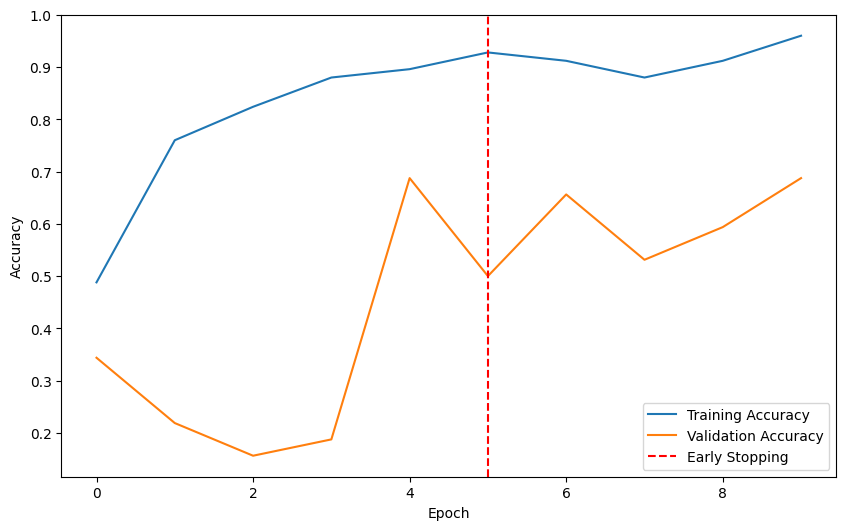

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


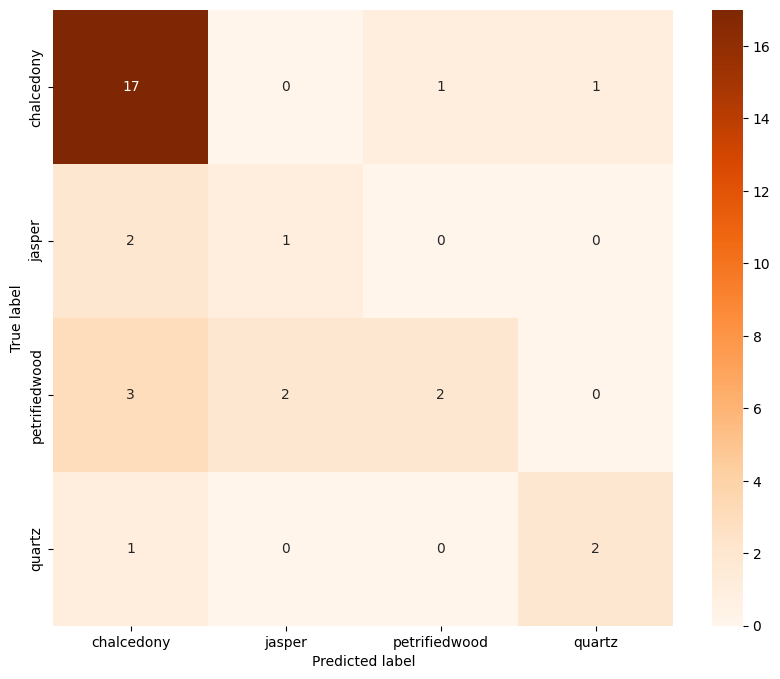

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = rockhound_model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {test_accuracy}")

early_stop_epoch = early_stop.best_epoch + 1

# Plotting training loss vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(x=early_stop_epoch, color='red', linestyle='--', label='Early Stopping')
plt.legend(loc='lower right')
plt.show()

# The models predictions
predictions = rockhound_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Actual class
y_true = np.argmax(y_test, axis=1)

# Class names corresponding to your labels
classes = ['chalcedony', 'jasper', 'petrifiedwood', 'quartz']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Breakdown of Results
Currenly validation accuracy is at 68% which is quite low. However, this number is actually misleadingly 'high' since the data is extremely unbalanced. The high accuracy with chalcedony skews the accuracy, and seems to have led to a bias towards that class. One thing to note, incorporating early stopping has improved the generaliztion gap.


## Reflection
#### __Challenges__
- __Data Collection:__ <br>
Since the input data consists of images of rocks, collecting enough data to effectively train the model was/is difficult. This involved carefully selecting appropriate images for each class and deciding how in depth the class structure should be.

- __Model Accuracy:__ <br>
CNN's require a substantial amount of data to train effectively, and the nature of the classification target — rocks — adds complexity. Rocks within the same class can vary significantly in color, texture, and shape, making it difficult for the model to generalize and accurately differentiate between them.

#### __Future Work__
- __Increase Dataset Size:__ <br>
As mentioned above, manually collecting data proved to be a challenge. Given more time, I'd prioritize evening out the data per class, as well as increasing the dataset's overall size significantly.

- __Add More Classes for Identification:__ <br>
Due to complexity and time constraints I limited the model to only identifying 4 minerals, but this doesn't even scratch the surface for mineral identification. To improve the overall practicality of the model, more classes need to be added.

- __Additional hyperparameter tuning:__ <br>
With an increased(and even) dataset, additional hyperparameter tuning would be neccessary and could potentially provide more drastic improvements in model accuracy compared to what the hyperparameter tuning currently provides.